In [19]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

display(jax.devices())

from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

[cuda(id=0)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
OBS_NOISE = 0.1

def nonlin(x):
    return relu(x)

def model(X, Y, D_H, D_Y=3):
    N, D_X = X.shape

    # First Layer
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros(D_H), jnp.ones(D_H)))
    z1 = nonlin(jnp.dot(X, w1) + b1)

    # Second Layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros(D_H), jnp.ones(D_H)))
    z2 = nonlin(jnp.dot(z1, w2) + b2)

    # Third Layer
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    b3 = numpyro.sample("b3", dist.Normal(jnp.zeros(D_H), jnp.ones(D_H)))
    z3 = nonlin(jnp.dot(z2, w3) + b3)

    # Output Layer
    w4 = numpyro.sample("w4", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    b4 = numpyro.sample("b4", dist.Normal(jnp.zeros(D_Y), jnp.ones(D_Y)))
    z4 = jnp.dot(z3, w4) + b4

    sigma = jnp.eye(D_Y) * OBS_NOISE

    with numpyro.plate("data", N):
        numpyro.sample("Y", dist.MultivariateNormal(z4, sigma), obs=Y)

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


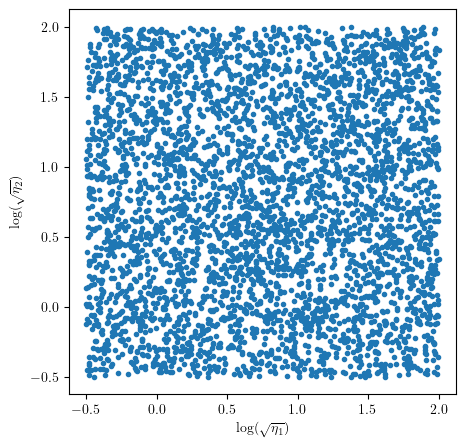

In [21]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

In [22]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float32)
y_train = jnp.array(y_scaled_train, dtype=jnp.float32)

In [25]:
sampler_params = {
    "num_warmup": 1000,
    "num_samples": 5000,
    "num_chains": 1
}

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 15e-5
trajectory_length = 2.501
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

Number of Steps:  16673


In [26]:
kernel = HMC(model, step_size=step_size, trajectory_length=trajectory_length, adapt_step_size=False)

mcmc = MCMC(kernel, **sampler_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train, 20)

warmup:   0%|          | 4/6000 [00:20<8:09:28,  4.90s/it, 16674 steps of size 1.50e-04. acc. prob=0.00] 